# Inspecting condition differences using HsMM

There are several ways to estimate and inspect condition differences:
1. Estimate separate stage durations across conditions
2. Estimate separate bump magnitudes across conditions
3. Estimate different models for each condition

To illustrate these approaches we will rely on a dataset not yet available (but should be soon). This dataset is the EEG of 19 participant in a decision making task with two conditions, one where participants were required to speed-up their response and another where they were required to be as accurate as possible.

In [2]:
## Loading libraries and data

import os
import mne
import numpy as np
import xarray as xr
import hsmm_mvpy as hsmm

path = '../HsMM_estimation_files/'
version = "100Hz"
cpus = 4

epoch_data = xr.open_dataset('../epoch_data_condition-wise_100Hz.nc')
hsmm_dat, PCs, explained_var, means = hsmm.utils.transform_data(epoch_data, 'participant', n_comp=10, return_weights=True)

raw = mne.io.read_raw_fif('../../../PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S10_raw.fif', preload=False, verbose=False)#loading for sensor position
raw.set_montage(mne.channels.make_standard_montage('biosemi64'));

## Applying HsMM for all conditions

For the two first applications we rely on a fit of HsMM on all the data.

In [4]:
hsmm_data = hsmm.utils.stack_data(hsmm_dat,'participant')
init = hsmm.models.hsmm(hsmm_data.data.T, hsmm_data.starts.data, hsmm_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

As we don't know yet the number of bumps, we will use the ```backward_estimation()``` method. This method first estimate the max_bump solution (defined based on the bump width and the minimum reaction time) then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood (see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_HsMM_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 bump solution. In order to be sure to explore the likelihood landscape we will also define random starting points for the initial guesses on parameters and magnitudes of the bumps. 

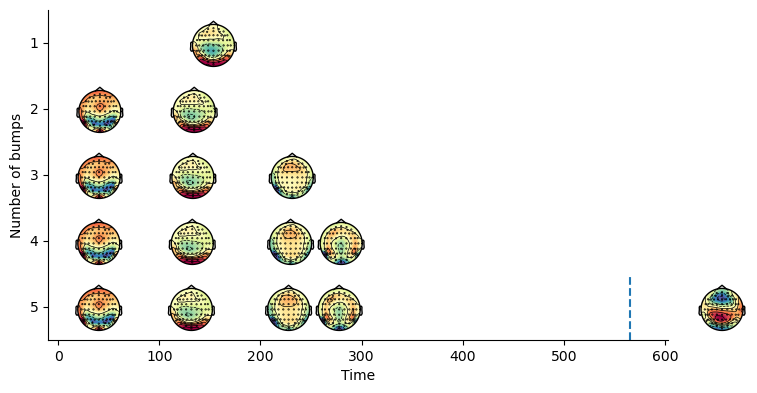

In [9]:
filename = 'SAT_bests_%s.nc'%version

if filename not in os.listdir(path):
    bests = init.backward_estimation(max_starting_points=200)
    bests.to_netcdf(path+filename)
else:
    bests = xr.open_dataset(path+filename)

    electrodes = xr.DataArray(hsmm.utils.reconstruct(bests.magnitudes, PCs, 
                            explained_var, means.data))

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init.bump_times(x),axis=0) for x in bests.eventprobs],
                          raw.pick_types(eeg=True).info, bump_size=init.bump_width_samples, time_step = 10, magnify=2, 
                          times_to_display = np.mean(hsmm_data.ends.data - hsmm_data.starts.data), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})

Next we test the required number of bumps with the LOOCV approache (see documentation 3)

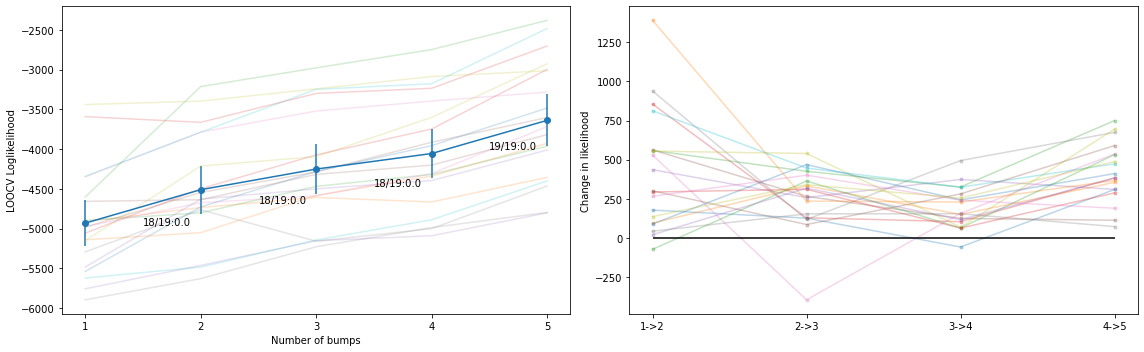

In [10]:
filename = 'SAT_loocv_%s.nc'%version

if filename not in os.listdir(path):
    temp = hsmm_data.unstack().data

    subjects_idx = epoch_data.participant.values
    likelihoods_loo = []

    all_n_bumps = []
    for n_bumps in np.arange(1,init.max_bumps+1):    
        with multiprocessing.Pool(processes=cpus) as pool:
            loo = pool.starmap(hsmm.utils.LOOCV, 
                zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                    itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
        all_n_bumps.append(loo)

    loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                               "participants":np.array(all_n_bumps)[0,:,1]})
    loocv.to_netcdf(path+filename)
else:
    loocv = xr.open_dataset(path+filename)
    loocv = loocv.rename({'__xarray_dataarray_variable__':'data'})#To correct
hsmm.visu.plot_LOOCV(loocv.data)

So we select 5 bumps and will keep this nomber across conditions for applications 1 and 2.

## 1. Estimate separate stage durations across conditions

In a design with a speed-accuracy trade-off such as this one, predictions on stages are rather straightforward. We expect that the main difference in latencies should be found in the decision stage although we can expect effects on other stages [Steinmann2018, Weindel2021]. To leave enough flexibility to the model we do not constrain the latencies to be fixed across conditions, but if we want to avoid extra degrees of freedom and test a hypothesis on a specific stage we can also fix stage duration as we do for magnitudes (see next application).

In [13]:
subset = hsmm_dat.where(epoch_data.event.str.contains('speed'),drop=True)
hsmm_speed_data = hsmm.utils.stack_data(subset,'participant')
init_speed = hsmm.models.hsmm(hsmm_speed_data.data.T, hsmm_speed_data.starts.data, hsmm_speed_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_magnitudes=False)#Here we turn off the estimation of magnitudes so only stage durations are free to vary

subset = hsmm_dat.where(epoch_data.event.str.contains('accuracy'),drop=True)
hsmm_accuracy_data = hsmm.utils.stack_data(subset,'participant')
init_accuracy = hsmm.models.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_magnitudes=False)

In [14]:
speed = init_speed.fit_single(5, magnitudes=bests.sel(n_bumps=5).magnitudes)#Having fixed magnitudes we need to pass this estimated from the previous iterative method
accuracy = init_accuracy.fit_single(5, magnitudes=bests.sel(n_bumps=5).magnitudes)

Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


In [15]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [speed, accuracy]):
    condition_times.append(cond[0].bump_times(cond[1].eventprobs.dropna('bump')))
condition_times = np.array(condition_times,dtype=object)


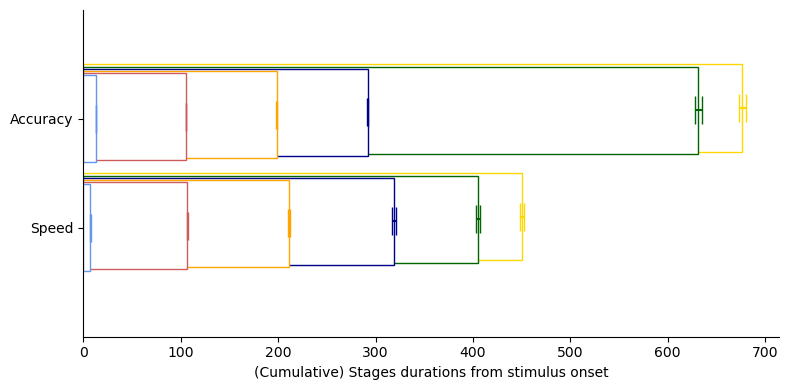

In [16]:
hsmm.visu.plot_latencies_average(condition_times, init.bump_width_samples, 1000/init.sf, 
                labels= ['Speed', 'Accuracy'], errs='ci');

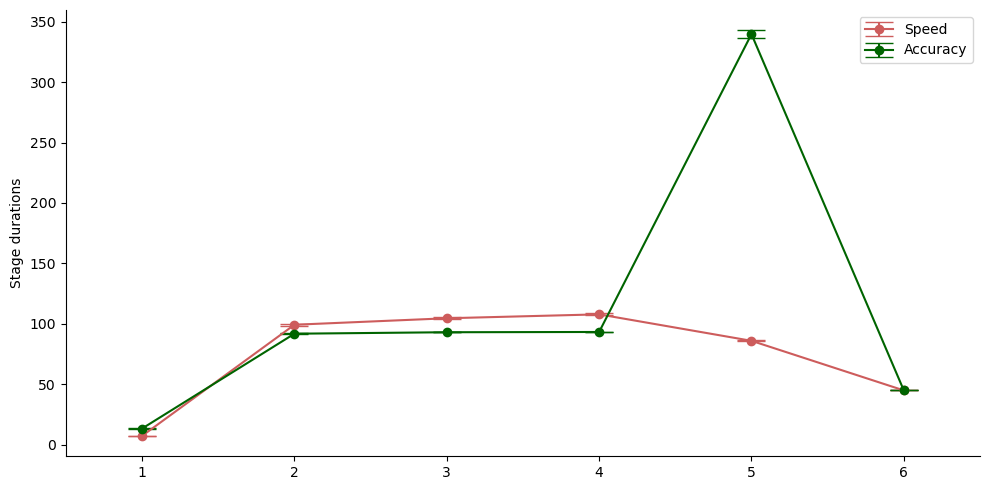

In [17]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels= ['Speed', 'Accuracy'], errs='ci', time_step=1000/init.sf,
    colors=["indianred","darkgreen"], figsize=(10,5));

We see indeed that the speed-accuracy is driven mainly by one stage which could then be the decision stage. The other stages remain relatively constant we could further analyze these differences with a statistical model.

## 2. Estimated different tpopologies across conditions (left and right stimulus)

Given the conditions used in the dataset, it's is hard to think of difference in topologies arising from a condition where participant have to speed up *vs* a condition where they have to be accurate. A more interesting analysis regarding topologies would by stimulation response. Assuming that enough responses are correct (they aren't) we should be able to see Lateralized Readiness Potential congruent with the stimulation side, and as we expect this effect to be located on the bump representing response execution we could choose to only estimate this on the last bump.

In [18]:
subset = hsmm_dat.where(epoch_data.event.str.contains('left'),drop=True)
hsmm_l_data = hsmm.utils.stack_data(subset,'participant')
init_l = hsmm.models.hsmm(hsmm_l_data.data.T, hsmm_l_data.starts.data, hsmm_l_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_parameters=False, magnitudes_to_fix=[0,1,2,3])

subset = hsmm_dat.where(epoch_data.event.str.contains('right'),drop=True)
hsmm_r_data = hsmm.utils.stack_data(subset,'participant')
init_r = hsmm.models.hsmm(hsmm_r_data.data.T, hsmm_r_data.starts.data, hsmm_r_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_parameters=False, magnitudes_to_fix=[0,1,2,3])

In [19]:
left_stim = init_l.fit_single(5, parameters=bests.sel(n_bumps=5).parameters,magnitudes=bests.sel(n_bumps=5).magnitudes)
right_stim = init_r.fit_single(5, parameters=bests.sel(n_bumps=5).parameters,magnitudes=bests.sel(n_bumps=5).magnitudes)

Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


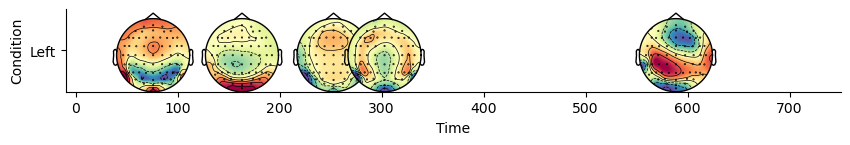

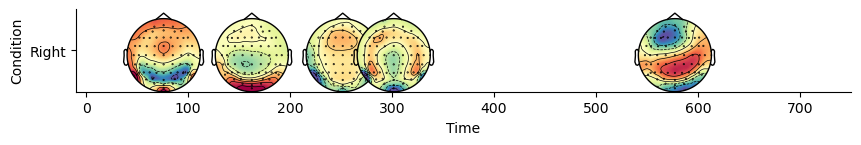

In [20]:
for condition in zip([left_stim, right_stim],
                     [init_l, init_r],
                     [hsmm_l_data, hsmm_r_data],
                    ['Left', 'Right']):
    electrodes = xr.DataArray(hsmm.utils.reconstruct(condition[0].magnitudes, PCs, explained_var, means.data))
    hsmm.visu.plot_topo_timecourse(electrodes, np.mean(condition[1].bump_times(condition[0].eventprobs), axis=0),
                          raw.pick_types(eeg=True).info, bump_size=condition[1].bump_width_samples, time_step = 10,  
                          times_to_display = np.mean(condition[2].ends.data - condition[2].starts.data),max_time=750,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=5)

Success, the only bump that changed in magnitude is the last one as imposed.

[Coming section : LOOCV for conditions]

# 3. Estimate different models for each condition


Lastly we can fit two completely separate models to the two speed-accuracy conditions. This is the most flexible approach and requires enough data in each condition, it should however systematically been tested when there is a suspicion on a difference on number of stages as the two previous applications assumed the same number of stage

### Applying HsMM separately for the speed condition

Initializing data for the speed condition

In [21]:
subset = hsmm_dat.where(epoch_data.event.str.contains('speed'),drop=True)
hsmm_speed_data = hsmm.utils.stack_data(subset,'participant')
init_speed = hsmm.models.hsmm(hsmm_speed_data.data.T, hsmm_speed_data.starts.data, hsmm_speed_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

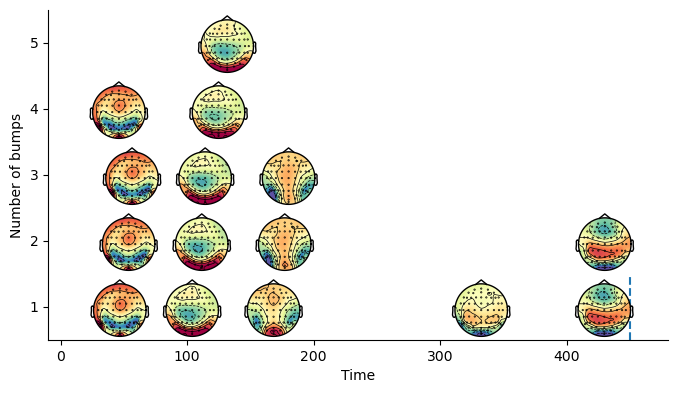

In [32]:
filename = 'SAT_bests_speed_%s.nc'%version

if filename not in os.listdir(path):
    bests_speed = init.backward_estimation(max_starting_points=200)
    bests_speed.to_netcdf(path+filename)
else:
    bests_speed = xr.open_dataset(path+filename)

electrodes = xr.DataArray(hsmm.utils.reconstruct(bests_speed.magnitudes, PCs, 
                            explained_var, means.data))

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init_speed.bump_times(x),axis=0) for x in bests_speed.eventprobs],
                          raw.pick_types(eeg=True).info, bump_size=init_speed.bump_width_samples, time_step = 10, magnify=2, 
                          times_to_display = np.mean(hsmm_speed_data.ends.data - hsmm_speed_data.starts.data), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init_speed.max_bumps)+1})

Compute LOOCV on speed data only

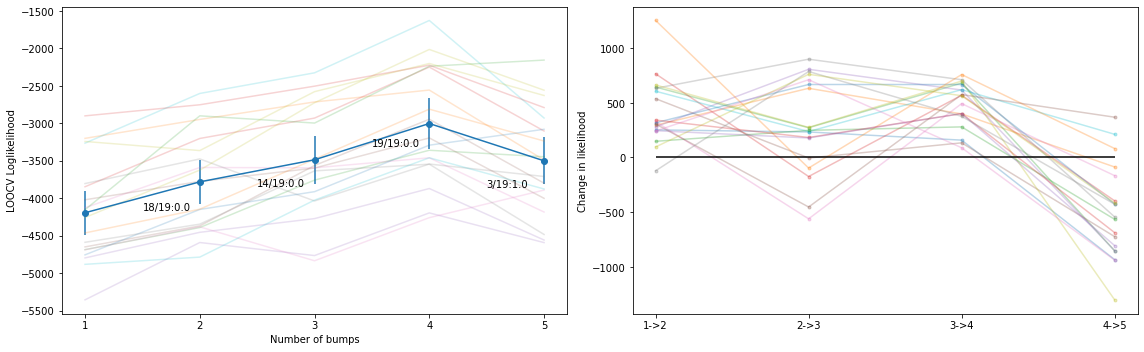

In [23]:
filename = 'SAT_loocv_speed_%s.nc'%version

if filename not in os.listdir(path):
    temp = hsmm_data.unstack().data

    subjects_idx = epoch_data.participant.values
    likelihoods_loo = []

    all_n_bumps = []
    for n_bumps in np.arange(1,init.max_bumps+1):    
        with multiprocessing.Pool(processes=cpus) as pool:
            loo = pool.starmap(hsmm.utils.LOOCV, 
                zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                    itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
        all_n_bumps.append(loo)

    loocv_speed = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                               "participants":np.array(all_n_bumps)[0,:,1]})
    loocv_speed.to_netcdf(path+filename)
else:
    loocv_speed = xr.open_dataset(path+filename)
    loocv_speed = loocv_speed.rename({'__xarray_dataarray_variable__':'data'})#To correct
hsmm.visu.plot_LOOCV(loocv_speed.data)

This shows that the number of bumps selected in the speed condition is lower than whn all the data was used as in the applications above.

### Applying HsMM separately for the accuracy condition

Initializing data for the accuracy condition

In [24]:
subset = hsmm_dat.where(epoch_data.event.str.contains('accuracy'),drop=True)
hsmm_accuracy_data = hsmm.utils.stack_data(subset,'participant')
init_accuracy = hsmm.models.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

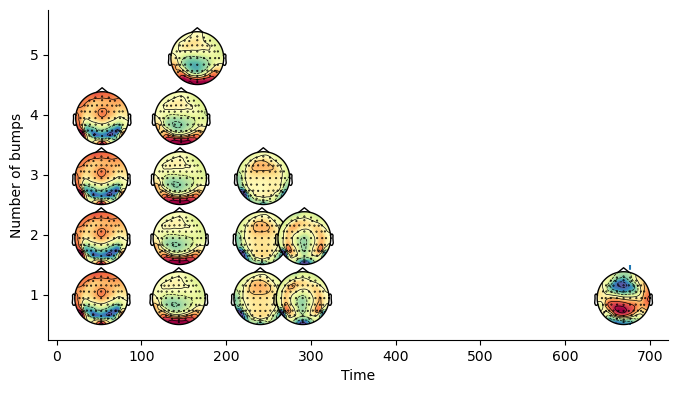

In [33]:
filename = 'SAT_bests_accuracy_%s.nc'%version

if filename not in os.listdir(path):
    bests_accuracy = init.backward_estimation(max_starting_points=200)
    bests_accuracy.to_netcdf(path+filename)
else:
    bests_accuracy = xr.open_dataset(path+filename)

electrodes = xr.DataArray(hsmm.utils.reconstruct(bests_accuracy.magnitudes, PCs, 
                            explained_var, means.data))

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init_accuracy.bump_times(x),axis=0) for x in bests_accuracy.eventprobs],
                          raw.pick_types(eeg=True).info, bump_size=init_speed.bump_width_samples, time_step = 10, magnify=3, 
                          times_to_display = np.mean(hsmm_accuracy_data.ends.data - hsmm_accuracy_data.starts.data), 
                          figsize=(8,4), ylabels={'Number of bumps':np.arange(init_speed.max_bumps)+1})

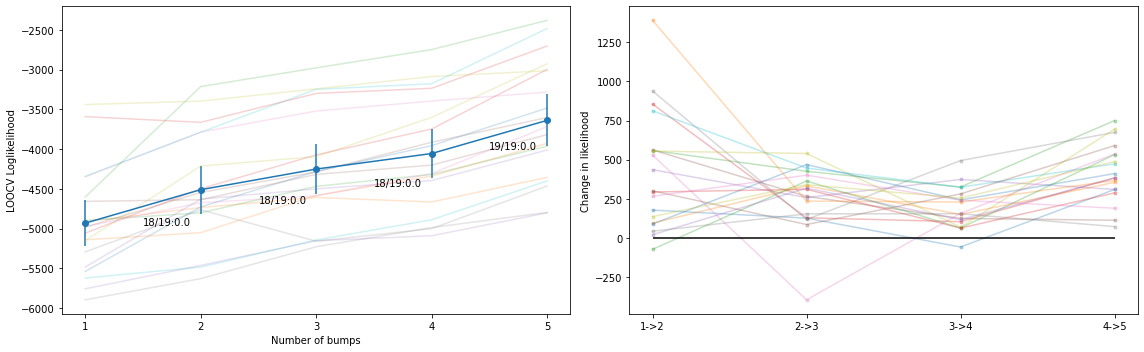

In [26]:
filename = 'SAT_loocv_accuracy_%s.nc'%version

if filename not in os.listdir(path):
    temp = hsmm_data.unstack().data

    subjects_idx = epoch_data.participant.values
    likelihoods_loo = []

    all_n_bumps = []
    for n_bumps in np.arange(1,init.max_bumps+1):    
        with multiprocessing.Pool(processes=cpus) as pool:
            loo = pool.starmap(hsmm.utils.LOOCV, 
                zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                    itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
        all_n_bumps.append(loo)

    loocv_accuracy = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                               "participants":np.array(all_n_bumps)[0,:,1]})
    loocv_accuracy.to_netcdf(path+filename)
else:
    loocv_accuracy = xr.open_dataset(path+filename)
    loocv_accuracy = loocv_accuracy.rename({'__xarray_dataarray_variable__':'data'})#To correct
hsmm.visu.plot_LOOCV(loocv_accuracy.data)

In the case of the accuracy condition we have one more bump, the same number as when the HsMM was fitted on the pooled data. The observation of an additional stage in accuracy using  HsMM-MVPA was already found by [Van Maanen, Portoles, & Borst (2021)](https://link.springer.com/article/10.1007/s42113-021-00105-2).

Despite having different models we can still compare the magnitudes as well as the latencies:

In [27]:
estimates_speed = bests_speed.sel(n_bumps=4).drop_vars('n_bumps')
estimates_accuracy = bests_accuracy.sel(n_bumps=5).drop_vars('n_bumps')

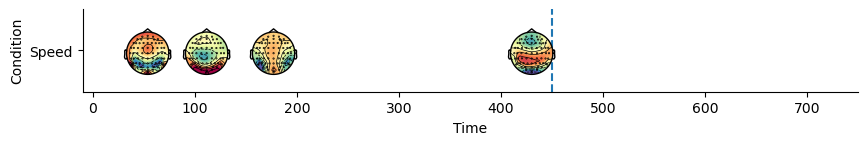

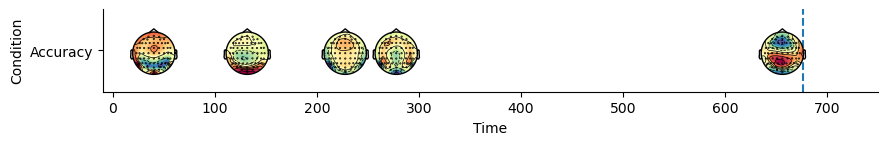

In [28]:
for condition in zip([estimates_speed, estimates_accuracy],
                     [init_speed, init_accuracy],
                     [hsmm_speed_data, hsmm_accuracy_data],
                    ['Speed', 'Accuracy']):
    electrodes = xr.DataArray(hsmm.utils.reconstruct(condition[0].magnitudes, PCs, explained_var, means.data))
    hsmm.visu.plot_topo_timecourse(electrodes, np.mean(condition[1].bump_times(condition[0].eventprobs), axis=0),
                          raw.pick_types(eeg=True).info, bump_size=condition[1].bump_width_samples, time_step = 10,  
                          times_to_display = np.mean(condition[2].ends.data - condition[2].starts.data),max_time=750,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=2)

In [29]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [estimates_speed, estimates_accuracy]):
    condition_times.append(cond[0].bump_times(cond[1].eventprobs.dropna('bump')))
condition_times = np.array(condition_times,dtype=object)

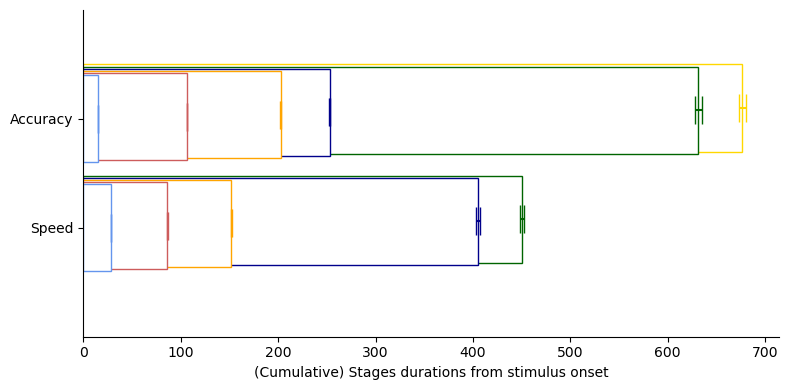

In [30]:
hsmm.visu.plot_latencies_average(condition_times, init.bump_width_samples, 1000/init.sf, 
                labels= ['Speed', 'Accuracy'], errs='ci');

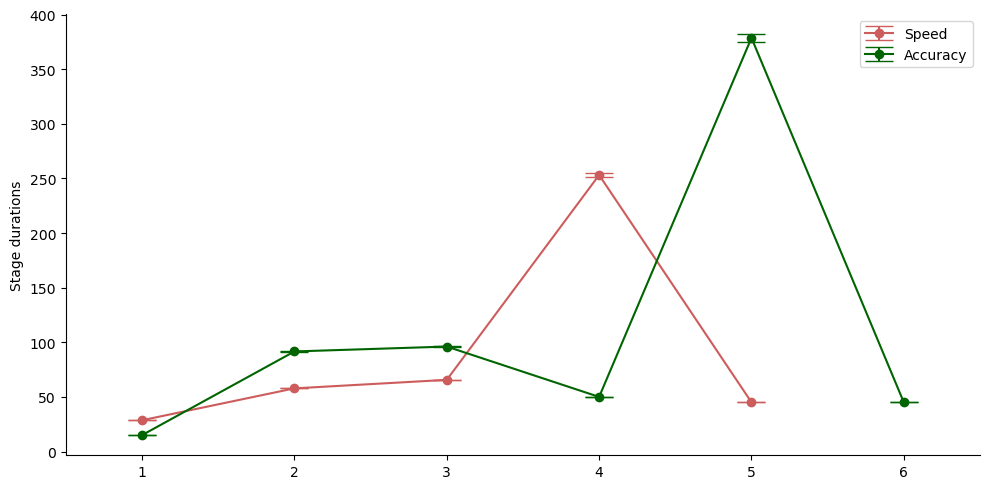

In [31]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels= ['Speed', 'Accuracy'], errs='ci', time_step=1000/init.sf,
    colors=["indianred","darkgreen"], figsize=(10,5));